following https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/04-One-Dimensional-Kalman-Filters.ipynb

## Kalman Gain

\begin{align}
\mu &= \frac{\bar \sigma^2 \mu_z + \sigma_z^2 \bar \mu}{\bar \sigma^2 + \sigma_z^2} \\
&= \bar \mu + K (\mu_z - \bar \mu)
\end{align}

where the Kalman gain is defined as $K=\frac{\bar \sigma^2}{\bar \sigma^2 + \sigma_z^2}$. 관측이 믿을만한 경우 $\sigma_z \rightarrow 0$이고, $K \rightarrow 1$이라 관측 결과를 그대로 읽으면 된다. 즉 $\mu \rightarrow \mu_z$가 된다. 반대인 경우 관측 분산이 상대적으로 커서 관측 결과를 내부 상태의 반영으로 그대로 간주하기 힘들기에 $K \rightarrow 0$이 되어 $\mu \rightarrow \bar \mu$가 된다.

## Kalman filter

<u>**Predict**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
\bar \mu = \mu + \mu_{f_x} & \bar x = x + dx & \bar{\mathbf x} = \mathbf{Fx} + \mathbf{Bu}\\
\bar\sigma^2 = \sigma_x^2 + \sigma_{f_x}^2 & \bar P = P + Q & \bar{\mathbf P} = \mathbf{FPF}^\mathsf T + \mathbf Q \\
\hline
\end{array}$

<u>**Update**</u>

$\begin{array}{|l|l|l|}
\hline
\text{Univariate} & \text{Univariate} & \text{Multivariate}\\
& \text{(Kalman form)} & \\
\hline
& y = z - \bar x & \mathbf y = \mathbf z - \mathbf{H\bar x} \\
& K = \frac{\bar P}{\bar P+R}&
\mathbf K = \mathbf{\bar{P}H}^\mathsf T (\mathbf{H\bar{P}H}^\mathsf T + \mathbf R)^{-1} \\
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2} & x = \bar x + Ky & \mathbf x = \bar{\mathbf x} + \mathbf{Ky} \\
\sigma^2 = \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2} & P = (1-K)\bar P &
\mathbf P = (\mathbf I - \mathbf{KH})\mathbf{\bar{P}} \\
\hline
\end{array}$

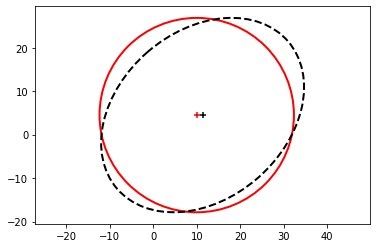

In [4]:
import numpy as np
from filterpy.kalman import predict
from filterpy.stats import plot_covariance_ellipse


dt = 0.3
F = np.array([[1, dt], [0, 1]])
x = np.array([10.0, 4.5])
P = np.diag([500, 500])
plot_covariance_ellipse(x, P, edgecolor='r')
x, P = predict(x, P, F, Q=0)
plot_covariance_ellipse(x, P, edgecolor='k', ls='dashed')

In [5]:
x, P

(array([11.35,  4.5 ]), array([[545., 150.],
        [150., 500.]]))

In [6]:
from filterpy.common import Q_discrete_white_noise
Q = Q_discrete_white_noise(dim=2, dt=1.0, var=2.35)
print(Q)

[[0.5875 1.175 ]
 [1.175  2.35  ]]


## Implementing the Kalman filter

In [1]:
import numpy as np
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

def pos_vel_filter(x, P, R, Q=0.0, dt=1.0):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([x[0], x[1]])
    kf.F = np.array([[1.0, dt], [0.0, 1.0]])
    kf.H = np.array([[1.0, 0.0]])
    kf.R *= R
    if np.isscalar(P):
        kf.P *= P
    else:
        kf.P[:] = P
    if np.isscalar(Q):
        kf.Q = Q_discrete_white_noise(dim=2, dt=dt, var=Q)
    else:
        kf.Q[:] = Q
    return kf

In [2]:
dt = 0.1
x = np.array([0.0, 0.0])
kf = pos_vel_filter(x, P=500, R=5, Q=0.1, dt=dt)
kf

KalmanFilter object
dim_x = 2
dim_z = 1
dim_u = 0
x = [0. 0.]
P = [[500.   0.]
     [  0. 500.]]
x_prior = [[0. 0.]].T
P_prior = [[1. 0.]
           [0. 1.]]
x_post = [[0. 0.]].T
P_post = [[1. 0.]
          [0. 1.]]
F = [[1.  0.1]
     [0.  1. ]]
Q = [[2.5e-06 5.0e-05]
     [5.0e-05 1.0e-03]]
R = [[5.]]
H = [[1. 0.]]
K = [[0. 0.]].T
y = [[0.]]
S = [[0.]]
SI = [[0.]]
M = [[0.]]
B = None
z = [[None]]
log-likelihood = -708.3964185322641
likelihood = 2.2250738585072014e-308
mahalanobis = 0.0
alpha = 1.0
inv = <function inv at 0x7f7288498950>

In [4]:
def compute_dog_data(z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    x, vel = 0., 1.
    z_std = np.sqrt(z_var)
    p_std = np.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (np.random.randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + np.random.randn() * z_std)        
    return np.array(xs), np.array(zs)



R = 10
Q = 1
P = np.diag([500, 49.])
count = 50

track, zs = compute_dog_data(R, Q, count)

x0 = (0., 0.)
dt = 0.1
kf = pos_vel_filter(x0, R=R, P=P, Q=Q, dt=dt)
xs, cov = [], []
for z in zs:
    kf.predict()
    kf.update(z)
    xs.append(kf.x)
    cov.append(kf.P)

xs, cov = np.array(xs), np.array(cov)

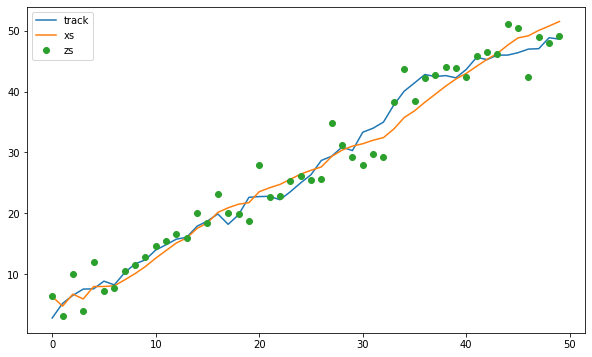

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, figsize=(10, 6))
ax.plot(track)
ax.plot(xs[:, 0])
ax.plot(zs, 'o')
ax.legend(['track', 'xs', 'zs'])

In [43]:
cov1 = map(lambda x: x.diagonal(), cov)
cov1 = np.vstack(list(cov1))

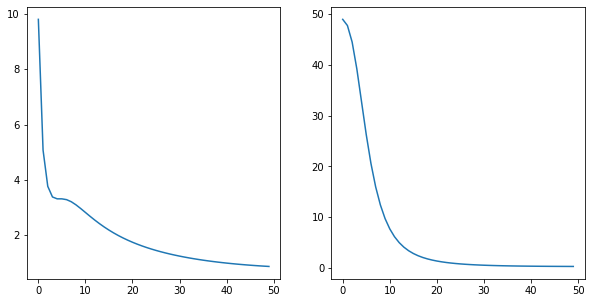

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(cov1[:, 0])
axs[1].plot(cov1[:, 1])